In [22]:
####%%%%%!pip install autograd
########!pip install tensorflow

In [23]:
import tensorflow as tf
import autograd.numpy as np
from autograd import grad 
import autograd.numpy.random as npr
from autograd.core import primitive
from matplotlib import pyplot as plt
%matplotlib inline

In [24]:
nx = 11
Tfinal=1
dx = Tfinal / (nx-1)

In [25]:
def A(x):
    '''Left part of initial equation    '''
    return 1/5.
def B(x):
    '''Right part of initial equation'''
    return np.exp(-x/5)*np.cos(x)
def f(x, psy):
    '''d(psy)/dx = f(x, psy)This is f() function on the right'''
    return np.exp(-x/5)*np.cos(x) - psy /5.
def psy_analytic(x):
    ''' Analytical solution of current problem'''
    return np.exp(-x/5)*np.sin(x) 
IC = 0.

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ] 0.1


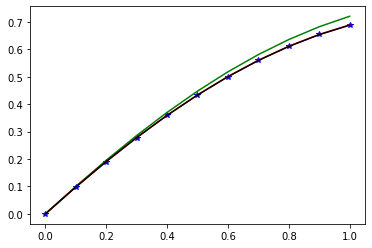

In [26]:
x_space = np.linspace(0, Tfinal, nx)    
y_space = psy_analytic(x_space)
print(x_space,dx)

psy_fd1 = np.zeros_like(y_space)
psy_fd1[0] = IC # IC
psy_fd2 = np.zeros_like(y_space)
psy_fd2[0] = IC # IC
psy_fd3 = np.zeros_like(y_space)
psy_fd3[0] = IC 
psy_fdd = np.zeros_like(y_space)

n=1
for i in range(1, len(x_space)):
    psy_fd1[i] = psy_fd1[i-1]  + dx*f(x_space[i-1],psy_fd1[i-1])

for i in range(1, len(x_space)):
    psy_fd2[i] = psy_fd2[i-1] + dx*f(x_space[i-1]+dx/2, psy_fd2[i-1]+dx*f(x_space[i-1],psy_fd2[i-1])/2)
    
for i in range(1, len(x_space)):
    psy_fdd[i] = psy_fd3[i-1]  + dx*f(x_space[i-1],psy_fd3[i-1])
    psy_fd3[i] = psy_fd3[i-1] + dx*(f(x_space[i-1],psy_fd3[i-1])+f(x_space[i],psy_fdd[i]))/2

psy_fd = psy_fd1
plt.figure()
plt.plot(x_space, y_space, 'b*')
plt.plot(x_space, psy_fd1, 'g')
plt.plot(x_space, psy_fd2, 'r')
plt.plot(x_space, psy_fd3, 'k')
plt.show()

In [27]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_grad(x):
    return sigmoid(x) * (1 - sigmoid(x))

def neural_network(W, x):
    a1 = sigmoid(np.dot(x, W[0]))
    return np.dot(a1, W[1])

def d_neural_network_dx(W, x, k=1):
    return np.dot(np.dot(W[1].T, W[0].T**k), sigmoid_grad(x))

def loss_function(W, x, yhat):
    loss_sum = 0
    for i in range(0,len(x)):
        net_out = neural_network(W, x[i])[0][0]
        psy_t = yhat[i] +  x[i]**(n+1)*net_out

        d_net_out = d_neural_network_dx(W, x[i])[0][0]
        d_psy_t = f(x[i],yhat[i])+ (n+1)*(x[i]**n)*net_out + x[i]**(n+1)* d_net_out

        func = f(x[i], psy_t)
        err_sqr = (d_psy_t - func)**2
        loss_sum += err_sqr
    return loss_sum


In [28]:
import time

lmb = 0.001 # init : 0.001
samples = 100 # best result 개수

base_error = y_space - psy_fd
data = {'best_res_time' : [], 'break_average' : [], 'error_total' : [], 'bad_res' : 0}

while len(data['best_res_time']) != samples:
    time_start = time.perf_counter()
    W = [npr.randn(1, 10), npr.randn(10, 1)]
    
    if (data['bad_res'] + len(data['best_res_time']))//3 == samples // 3:
        print('좋은 데이터 개수 {} / {} \n버려진 데이터 : {} 개 \n --------------'.format(len(data['best_res_time']), samples, data['bad_res']))

    for i in range(5000):
        loss_grad = grad(loss_function)(W, x_space,psy_fd)
        
        W[0] = W[0] - lmb * loss_grad[0]
        W[1] = W[1] - lmb * loss_grad[1]

        cnt = 0
        for xi in x_space:
            if neural_network(W, xi)[0] > 0:    # 1차 거르는 단계, 세번째는 초반부에 양수값으로 자리 잡기 시작하면 좋은 데이터가 잘 안나옴.
                continue
            else:
                cnt += 1

        y_error = y_space - (psy_fd + [xi**(n+1)*neural_network(W, xi)[0][0] for xi in x_space])
        if cnt == len(x_space) and i > 1:
            e_cnt = 0
            for b_e, y_e in zip(base_error, y_error):
                if abs(b_e) < abs(y_e):
                    pass
                else:
                    e_cnt += 1
                        
            if e_cnt == len(y_error) and np.linalg.norm(y_error) < np.linalg.norm(base_error):   # 결과 값의 모든 에러가 베이스 에러보다 낮을 때 좋은 결과 데이터에 저장.
                data['best_res_time'].append(time.perf_counter() - time_start)
                data['break_average'].append(i)
                data['error_total'].append(np.linalg.norm(y_error))
                data['bad_res'] -= 1
                break

    data['bad_res'] += 1

좋은 데이터 개수 2 / 10, 반복문 진행 상황 :  24%|██▍       | 1222/5000 [00:13<00:42, 89.22it/s]

In [ ]:
print ("세번째 코드 \n ------------- \n 총 데이터 개수 : {4} \n 결과가 좋은 데이터 개수 : {0} 개 \n 결과가 나쁜 데이터 개수 : {3} 개 \n -------------- \n 결과가 좋은 데이터 \n 평균 초 : {1:.1f} 초 \n 데이터 한개당 반복 횟수 : {2:} 번 \n 평균 에러 : {5:.5f} \n -------- \n 원본 에러 : {6:.5f} ".format(len(data['best_res_time']), sum(data['best_res_time']) / samples, sum(data['break_average']) / samples, data['bad_res'], data['bad_res'] + samples, sum(data['error_total']) / samples, np.linalg.norm(base_error)))

세번째 코드 
 ------------- 
 총 데이터 개수 : 6 
 결과가 좋은 데이터 개수 : 3 개 
 결과가 나쁜 데이터 개수 : 3 개 
 -------------- 
 결과가 좋은 데이터 
 평균 초 : 19.8 초 
 데이터 한개당 반복 횟수 : 1843.6666666666667 번 
 평균 에러 : 0.046030061983268235


Text(0, 0.5, 'Error')

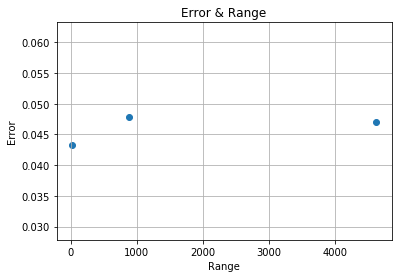

In [ ]:
plt.scatter(data['break_average'], data['error_total'])
plt.title('Error & Range')   # 반복 횟수에 따른 에러 분포도
plt.grid(b = True)
plt.xlabel('Range')  # 반복 횟수
plt.ylabel('Error')  # 에러

In [ ]:
data['error_total']

[0.0478314688542341, 0.04325261907011643, 0.04700609802545418]

[array([-0.00803082]), array([-0.00557423]), array([-0.00333713]), array([-0.0015325]), array([-0.00036068]), array([-3.92514921e-06]), array([-0.0006219]), array([-0.00234837]), array([-0.00528908]), array([-0.0095209]), array([-0.01509209])]


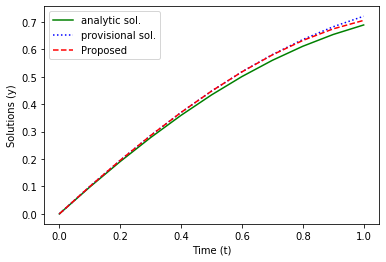

In [ ]:
res =  psy_fd + [xi**(n+1)*neural_network(W, xi)[0][0] for xi in x_space]

aa= [neural_network(W, xi)[0] for xi in x_space]
print(aa)
beingsaved = plt.figure()
plt.plot(x_space, y_space, 'g-',label='analytic sol.') 
plt.plot(x_space, psy_fd, 'b:',label='provisional sol.')
plt.plot(x_space, res, 'r--',label='Proposed')
plt.xlabel('Time (t)')
plt.ylabel('Solutions (y)')
plt.legend()
plt.show()

In [ ]:
print(np.linalg.norm(y_space - res))    # 빨간색 에러
print(np.linalg.norm(y_space - psy_fd)) # 파란색 에러

0.04700609802545418
0.05942444747896128


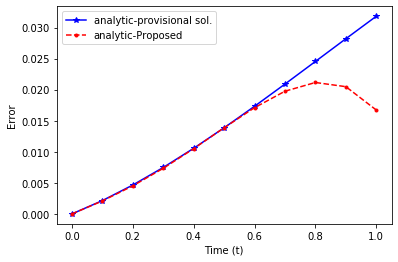

In [ ]:
beingsaved1 = plt.figure()
plt.plot(x_space, abs(y_space-psy_fd), 'b*-',label='analytic-provisional sol.') 
plt.plot(x_space, abs(y_space-res), 'r.--',label='analytic-Proposed')
plt.xlabel('Time (t)')
plt.ylabel('Error')
plt.legend()
plt.show()

In [ ]:
print(abs(y_space-psy_fd))
print(psy_fd)
print(res)

[0.         0.00214342 0.00465078 0.00747288 0.01055943 0.01385959
 0.01732253 0.02089792 0.02453644 0.02819023 0.03181333]
[0.         0.1        0.19553018 0.28578333 0.37003787 0.44766176
 0.51811548 0.58095387 0.63582698 0.68247987 0.7207515 ]
[0.         0.09994426 0.19539669 0.28564541 0.36998016 0.44766078
 0.51789159 0.57980317 0.63244197 0.67476794 0.70565941]
